In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from statistics import mean, stdev
import seaborn as sns
from itertools import chain
import math
import re
import nltk
nltk.download('words')
from nltk.corpus import words
from fuzzywuzzy import fuzz
import time

[nltk_data] Downloading package words to
[nltk_data]     C:\Users\202679\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
c:\Handelsdaten_Code\venv\Lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


## Data Extraction

In [8]:
column_translations = {'海关编码': 'HS_Code', 
                       '详细产品名称': 'Detailed_Description',
                       '日期': 'Date',
                       '印度进口商': 'Indian_Importer',
                       '数量单位': 'Quantity_Units',
                       '数量': 'Quantity',
                       '美元总金额': 'Total_Dollar_Amount',
                       '美元单价': 'USD_Unit_Price',
                       '卢比总金额': 'Total_Rupees_Amount',
                       '卢比单价': 'Rupees_Unit_Price',
                       '成交外币金额': 'Trans_Amount_Foreign_Currency',
                       '成交外币单价': 'Trans_Unit_Price_Foreign_Currency',
                       '币种': 'Currency',
                       '月度': 'Monthly',
                       '国外出口商': 'Foreign_Exporter',
                       '产销洲': 'Export_Continent',
                       '印度目的港': 'Entry_Port',
                       '国外装货港': 'Shipping_Port',
                       '产品描述': 'Product_Description',
                       '卢比总税费': 'Rupees_Total_Taxes',
                       '关单号': 'Customer_Order_Number',
                       '印度港口代码': 'Indian_Port_Code',
                       '运输方式': 'Transport_Method',
                       '报关行': 'Transport_Company',
                       '报关行代码': 'Transport_Company_Code',
                       '进口商地址': 'Importer_Address',
                       '进口商邮编': 'Importer_Zip_Code',
                       '进口商企业编码': 'Importer_Company_Code',
                       '进口商城市': 'Importer_City',
                       '出口商地址': 'Exporter_Address',
                       '合同号': 'Contract_No',
                       '进出口': 'Import_Or_Export'}

use_cols = ["海关编码", '详细产品名称', '日期', '印度进口商', '数量单位', '数量', '美元总金额', '美元单价', '卢比总金额', '卢比单价', '成交外币金额', '成交外币单价', '币种', '国外出口商', '产品描述', '进口商地址']

In [10]:
#Load suplliers with their aliases

suppliers = pd.read_excel("K:\DESDN\mbd\pm\mpm_pma/00_Projekte\CSMO\Market Assessment\Market APAC\India\Handelsdatenprojekt/Daten/Supplier Names India.xlsx", header=2)

suppliers = suppliers.to_dict('list')

def is_nan(value):
    try:
        return math.isnan(value)
    except:
        return False

for key, value_list in suppliers.items():
    suppliers[key] = [value for value in value_list if not is_nan(value)]

<>:3: SyntaxWarning: invalid escape sequence '\D'
<>:3: SyntaxWarning: invalid escape sequence '\D'
C:\Users\202679\AppData\Local\Temp\ipykernel_24448\3500756359.py:3: SyntaxWarning: invalid escape sequence '\D'
  suppliers = pd.read_excel("K:\DESDN\mbd\pm\mpm_pma/00_Projekte\CSMO\Market Assessment\Market APAC\India\Handelsdatenprojekt/Daten/Supplier Names India.xlsx", header=2)


In [11]:
#Load model namings per supplier

models = pd.read_excel("K:\DESDN\mbd\pm\mpm_pma/00_Projekte\CSMO\Market Assessment\Market APAC\India\Handelsdatenprojekt\Daten\Model Mapping.xlsx")
models["Model Details"] = models["Model Details"].fillna('').astype(str)
models['Model Family'] = models['Model Family'].astype(str)

<>:3: SyntaxWarning: invalid escape sequence '\D'
<>:3: SyntaxWarning: invalid escape sequence '\D'
C:\Users\202679\AppData\Local\Temp\ipykernel_24448\718793704.py:3: SyntaxWarning: invalid escape sequence '\D'
  models = pd.read_excel("K:\DESDN\mbd\pm\mpm_pma/00_Projekte\CSMO\Market Assessment\Market APAC\India\Handelsdatenprojekt\Daten\Model Mapping.xlsx")


In [13]:
#Load raw trade data

base_dir = 'K:\DESDN\mbd\pm\mpm_pma/00_Projekte\CSMO\Market Assessment\Market APAC\India\Handelsdatenprojekt\Daten/'
subdirs = ['2021', '2022', '2023', '2024']

# Initialize an empty list to store the file paths
filenames = []

# Loop through each subdirectory
for subdir in subdirs:
    # Construct the full path to the subdirectory
    full_path = os.path.join(base_dir, subdir)
    
    # Check if the subdirectory exists
    if os.path.exists(full_path):
        # Loop through each file in the subdirectory
        for filename in os.listdir(full_path):
            # Construct the full path to the file
            file_path = os.path.join(full_path, filename)
            
            # Add the file path to the list
            filenames.append(file_path)

dfs = []

for file in filenames:
    dfs.append(pd.read_excel(os.path.join(base_dir, file), header=7, dtype={"数量": np.int64, '美元总金额': np.int64, '美元单价': np.int64, '卢比总金额': np.int64, '卢比单价': np.int64}, 
                             usecols=use_cols))

raw_data = pd.concat(dfs)
print(raw_data.head())

<>:3: SyntaxWarning: invalid escape sequence '\D'
<>:3: SyntaxWarning: invalid escape sequence '\D'
C:\Users\202679\AppData\Local\Temp\ipykernel_24448\505070620.py:3: SyntaxWarning: invalid escape sequence '\D'
  base_dir = 'K:\DESDN\mbd\pm\mpm_pma/00_Projekte\CSMO\Market Assessment\Market APAC\India\Handelsdatenprojekt\Daten/'


       海关编码                                             详细产品名称          日期  \
0  84143000  COMPRESSOR W11316286 TB1110Y WITH ACCESSORIES(...  2021/01/06   
1  84143000  51330740793YK COMPRESSOR EM 65HHR 220-240V/50H...  2021/01/06   
2  84143000             121L1393 COMPRESSOR MODEL HLJ072T4LC6   2021/01/06   
3  84213920  GPS-IMOD-66-SNAP WITH GPS-IMOD-PS WITH ACCESSO...  2021/01/06   
4  84143000  SAMPLE- COMPRESSOR FOR REFRIGERATOR WITH ACCES...  2021/01/06   

                                        印度进口商  数量单位    数量   美元总金额  美元单价  \
0                 WHIRLPOOL OF INDIA LIMITED   NOS   6480  141134    22   
1      WESTERN REFRIGERATION PRIVATE LIMITED   NOS   2760   67289    24   
2         DANFOSS INDUSTRIES PRIVATE LIMITED   NOS    168   33568   200   
3                        AIRCARE ENGINEERING   NOS      1    1907  1907   
4  SAMSUNG INDIA ELECTRONICS PRIVATE LIMITED   PCS     60    4752    79   

      卢比总金额    卢比单价    成交外币金额   成交外币单价    币种  \
0  10319725    1593  141134.0   

## Basic Data Transformation

In [14]:
#Translate column descriptions, drop unnecessary columns

raw_data.rename(columns=column_translations, inplace=True)
raw_data = raw_data.assign(Origin_Country='')

print(raw_data.head(), raw_data.info())

<class 'pandas.core.frame.DataFrame'>
Index: 332731 entries, 0 to 859
Data columns (total 17 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   HS_Code                            332731 non-null  int64  
 1   Detailed_Description               332728 non-null  object 
 2   Date                               332731 non-null  object 
 3   Indian_Importer                    332667 non-null  object 
 4   Quantity_Units                     332731 non-null  object 
 5   Quantity                           332731 non-null  int64  
 6   Total_Dollar_Amount                332731 non-null  int64  
 7   USD_Unit_Price                     332731 non-null  int64  
 8   Total_Rupees_Amount                332731 non-null  int64  
 9   Rupees_Unit_Price                  332731 non-null  int64  
 10  Trans_Amount_Foreign_Currency      332695 non-null  float64
 11  Trans_Unit_Price_Foreign_Currency  332695 non-n

In [15]:
# Convert na values of detailed description into string

raw_data['Detailed_Description'] = raw_data['Detailed_Description'].fillna('').astype(str)

In [16]:
#Convert date strings into datetime objects and sort by date

raw_data['Date'] = pd.to_datetime(raw_data['Date'], format="%Y/%m/%d")
raw_data.sort_values("Date", inplace=True)


In [17]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 332731 entries, 1114 to 432
Data columns (total 17 columns):
 #   Column                             Non-Null Count   Dtype         
---  ------                             --------------   -----         
 0   HS_Code                            332731 non-null  int64         
 1   Detailed_Description               332731 non-null  object        
 2   Date                               332731 non-null  datetime64[ns]
 3   Indian_Importer                    332667 non-null  object        
 4   Quantity_Units                     332731 non-null  object        
 5   Quantity                           332731 non-null  int64         
 6   Total_Dollar_Amount                332731 non-null  int64         
 7   USD_Unit_Price                     332731 non-null  int64         
 8   Total_Rupees_Amount                332731 non-null  int64         
 9   Rupees_Unit_Price                  332731 non-null  int64         
 10  Trans_Amount_Foreign_Curr

In [18]:
#Filter out suppliers which are car companies

raw_data['Foreign_Exporter'] = raw_data['Foreign_Exporter'].astype(str)

raw_data = raw_data[~raw_data['Foreign_Exporter'].str.contains('MERCEDES|DAIMLER|VOLVO|TOYOTA|FORD|HYUNDAI|JAGUAR', case=False, regex=True)]

## Add Total_Euro_Amount 

- Download current conversion rates whenever new Trade Data is downloaded from: https://data.ecb.europa.eu/data/datasets/EXR/EXR.D.USD.EUR.SP00.A
- Rename to USD_EUR.csv

In [19]:
USD_EUR = pd.read_csv(r"K:/DESDN/mbd/pm/mpm_pma/00_Projekte/CSMO/Market Assessment/Market APAC/India/Handelsdatenprojekt/Daten/USD_EUR.csv")

USD_EUR["DATE"] = pd.to_datetime(USD_EUR["DATE"], format=r"%Y-%m-%d")
USD_EUR.sort_values("DATE", inplace=True)

USD_EUR.set_index('DATE', inplace=True)
full_date_range = pd.date_range(start=USD_EUR.index.min(), end=USD_EUR.index.max())
USD_EUR = USD_EUR.reindex(full_date_range)

USD_EUR['US dollar/Euro (EXR.D.USD.EUR.SP00.A)'] = USD_EUR['US dollar/Euro (EXR.D.USD.EUR.SP00.A)'].ffill().bfill()

USD_EUR.reset_index(inplace=True)
USD_EUR.rename(columns={'index': 'DATE'}, inplace=True)

In [20]:
'''
def convert_currency(row, conversion=USD_EUR):
    
    print(type(row))
    print(conversion["DATE"])

    sel = conversion[conversion["DATE"] == row['Date']]
    #sel = conversion.merge(right=row, left_on="DATE", right_on="Date", how="inner")
    exchange_rate = sel.iloc[0]["US dollar/Euro (EXR.D.USD.EUR.SP00.A)"]

    return int(row["Total_Dollar_Amount"] / exchange_rate)

raw_data["Total_Euro_Amount"] = raw_data.apply(lambda x: convert_currency(x), axis=1)
'''

'\ndef convert_currency(row, conversion=USD_EUR):\n    \n    print(type(row))\n    print(conversion["DATE"])\n\n    sel = conversion[conversion["DATE"] == row[\'Date\']]\n    #sel = conversion.merge(right=row, left_on="DATE", right_on="Date", how="inner")\n    exchange_rate = sel.iloc[0]["US dollar/Euro (EXR.D.USD.EUR.SP00.A)"]\n\n    return int(row["Total_Dollar_Amount"] / exchange_rate)\n\nraw_data["Total_Euro_Amount"] = raw_data.apply(lambda x: convert_currency(x), axis=1)\n'

In [21]:
def USD_EUR_Conversion(data, USD_EUR):

    merged_data = data.merge(USD_EUR, left_on='Date', right_on='DATE', how='left')

    # Currency conversion
    merged_data['Total_Euro_Amount'] = merged_data['Total_Dollar_Amount'] / merged_data['US dollar/Euro (EXR.D.USD.EUR.SP00.A)']
    print(merged_data[merged_data['Total_Euro_Amount'].isna()])
    merged_data['Total_Euro_Amount'] = merged_data['Total_Euro_Amount'].astype(int)
    merged_data['Euros_Unit_Price'] = merged_data['USD_Unit_Price'] / merged_data['US dollar/Euro (EXR.D.USD.EUR.SP00.A)']
    merged_data['Euros_Unit_Price'] = merged_data['Euros_Unit_Price'].astype(int)

    # Drop the extra 'DATE' column from the merge if desired
    merged_data.drop(columns=['DATE', 'US dollar/Euro (EXR.D.USD.EUR.SP00.A)'], inplace=True)

    return merged_data

raw_data = USD_EUR_Conversion(raw_data, USD_EUR)

Empty DataFrame
Columns: [HS_Code, Detailed_Description, Date, Indian_Importer, Quantity_Units, Quantity, Total_Dollar_Amount, USD_Unit_Price, Total_Rupees_Amount, Rupees_Unit_Price, Trans_Amount_Foreign_Currency, Trans_Unit_Price_Foreign_Currency, Currency, Foreign_Exporter, Product_Description, Importer_Address, Origin_Country, DATE, TIME PERIOD, US dollar/Euro (EXR.D.USD.EUR.SP00.A), Total_Euro_Amount]
Index: []

[0 rows x 21 columns]


In [22]:
raw_data.head()

,HS_Code,Detailed_Description,Date,Indian_Importer,Quantity_Units,Quantity,Total_Dollar_Amount,USD_Unit_Price,Total_Rupees_Amount,Rupees_Unit_Price,Trans_Amount_Foreign_Currency,Trans_Unit_Price_Foreign_Currency,Currency,Foreign_Exporter,Product_Description,Importer_Address,Origin_Country,TIME PERIOD,Total_Euro_Amount,Euros_Unit_Price
0,84143000,"KF571001, COMPRESSOR SUITABLE FOR BOLERO",2021-01-01,MAHLE ANAND THERMAL SYSTEMS PRIVATE LIMITED,NOS,75,3690,49,269813,3598,3690.0,49.20,USD,UNNAYI(NANTONG)SCIEN-TECH CO. LTD.,Compressors for refrigerating equipment,"29,MILESTONE,PUNE-NASIK HIGHWAYKURULI,KHED",,NaN,3007,39
1,84212900,83630716 FUEL FILTER (COMPONENTS FOR CONSTRUCT...,2021-01-01,SCHWING STETTER (INDIA) PRIVATE LIMITED,PCS,15,168,11,12284,819,168.0,11.20,USD,XUZHOU RANRY IMP&EXP CO LTD,Machinery and apparatus for filtering or purif...,"F-71,SIPCOT INDL.PARK,SRIPERUMBUDURTALUK, IRUN...",,NaN,136,8
2,84212900,AF25667 AIR FILTER (C/O MX),2021-01-01,AGROMACH SPARES CORPORATION,NOS,18,477,27,34878,1938,477.0,26.50,USD,ILKERLER ENDUSTRI SATIS VE PAZALAMA A. S.,Machinery and apparatus for filtering or purif...,"JETHALAL MANSION, 3RD FLR.,10 BANK STREET*CROS...",,NaN,388,22
3,84148011,COMPRESSOR (MODEL NO. 1YC32CXD#A6) (MFR/BRAND:...,2021-01-01,DAIKIN AIRCONDITIONING INDIA PVT. LTD.,UNT,384,18140,47,1326397,3454,18140.0,47.24,USD,DAIKIN COMPRESSOR INDUSTRIES LTD.,"Air pumps, air or other gas compressors and ve...","F-25/2, OKHLA INDUSTRIAL AREA,PHASEII,",,NaN,14782,38
4,84212900,FF4052A FUEL FILTER (C/O IN),2021-01-01,AGROMACH SPARES CORPORATION,NOS,3,13,4,950,317,13.0,4.43,USD,ILKERLER ENDUSTRI SATIS VE PAZALAMA A. S.,Machinery and apparatus for filtering or purif...,"JETHALAL MANSION, 3RD FLR.,10 BANK STREET*CROS...",,NaN,10,3


## Exploration

In [23]:
#Exploration to make sense of amounts

sel_set = raw_data[raw_data["Quantity_Units"] == "SET"]

sel_other = raw_data[raw_data["Quantity_Units"] != "SET"]

sel_set = sel_set["Quantity"].to_list()
sel_other = sel_other["Quantity"].to_list()

print("Mean of Set Amounts:", mean(sel_set),
      "\nSdev of Set Amounts:", stdev(sel_set))

print("Mean of Other Amounts:", mean(sel_other),
      "\nSdev of Other Amounts:", stdev(sel_other))

Mean of Set Amounts: 809.3829944547135 
Sdev of Set Amounts: 2376.175429110913
Mean of Other Amounts: 903.8896731901957 
Sdev of Other Amounts: 33952.491367055634


317569


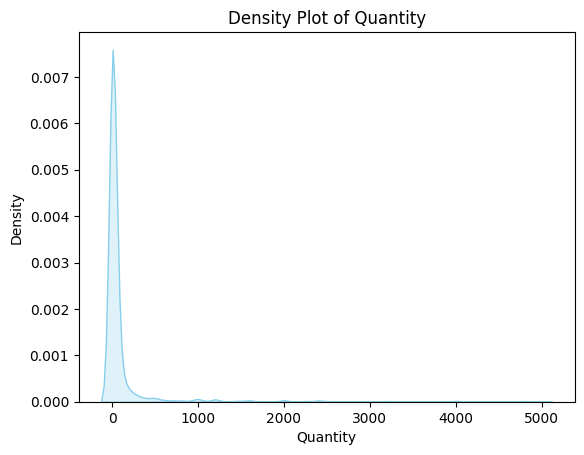

In [24]:
#Exploration to make sense of quantities

sel = raw_data[raw_data['Quantity'] < 5000]
print(len(sel))
sns.kdeplot(sel["Quantity"], fill=True, color='skyblue')
plt.xlabel('Quantity')
plt.ylabel('Density')
plt.title('Density Plot of Quantity')
plt.show()

## Drop Deliveries with Quantities <= 0

In [25]:
print("Anzahl Quantaties kleiner gleich 0:",len(raw_data[raw_data["Quantity"] <= 0].index))
print(raw_data[raw_data["Quantity"] <= 0])
raw_data = raw_data.drop(raw_data[raw_data["Quantity"] <= 0].index)

Anzahl Quantaties kleiner gleich 0: 227
         HS_Code                               Detailed_Description  \
1347    84212900  L STRAINER 305 PP-H/EPDM D20DN15 167305300 (2 ...   
3578    84212900  417-02 MOVING J/C STRAINER (S.P FOR DIE CASTIN...   
3646    84212900  417-01 FIXED J/C STRAINER (S.P FOR DIE CASTING...   
5754    84212900  FILTER\HILCO\SIMPLEX\MODEL NO 4960-00-682-C\FL...   
7472    84212900  431215, SYRINGE FILTER 15MM 0.2UM RC S (CASE1)...   
...          ...                                                ...   
322282  84212900                                    FILTER ELEMENT    
322299  84212900                    FILTER ELEMENT 0160 D010 BH4HC    
322351  84212900                     FILTER ELEMENT 0160 R010 P/HC    
322412  84212900                     FILTER ELEMENT 0240 R010 P/HC    
322418  84212900                                    FILTER ELEMENT    

             Date                                Indian_Importer  \
1347   2021-01-10  GEORG FISCHER PIPING

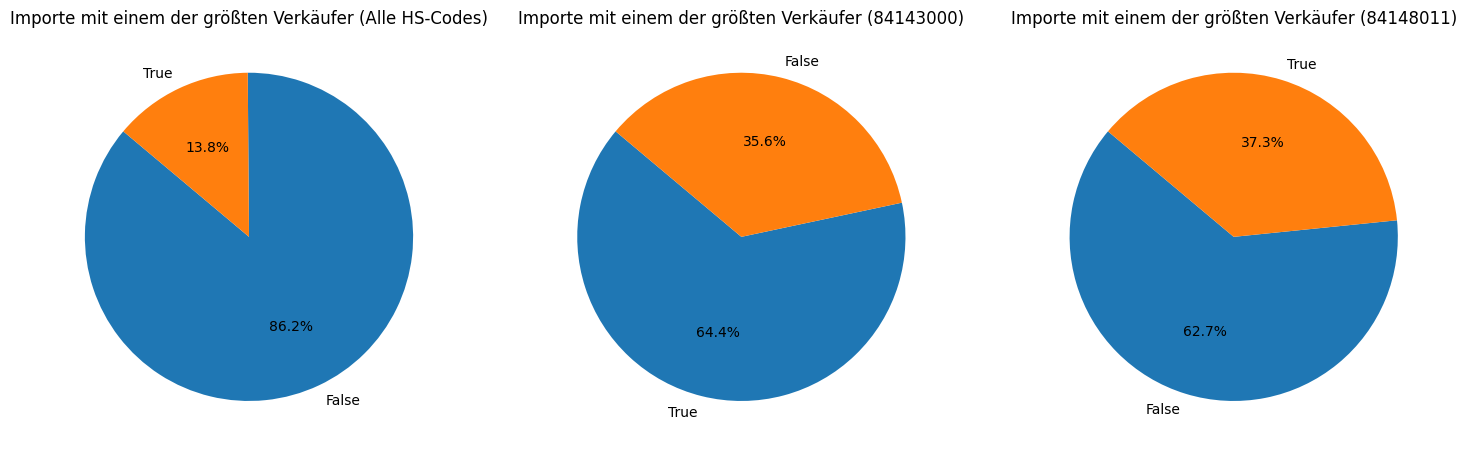

In [26]:
#Convert strings to upper case to make atring matching easier

raw_data ["Indian_Importer"] = raw_data["Indian_Importer"].str.upper()
raw_data ["Foreign_Exporter"] = raw_data["Foreign_Exporter"].str.upper()
raw_data ["Detailed_Description"] = raw_data["Detailed_Description"].str.upper()


In [ ]:
#Explore how many entries are of major competitors

sel1 = raw_data[raw_data['HS_Code'] == 84143000]
sel2 = raw_data[raw_data['HS_Code'] == 84148011]

substrings = ['Bock', 'Danfoss', 'Mayekawa', 'Dorin', 'Fujian', 'SRM', 'Comer', 'Fu Sheng', 'Daikin', 'J&E', 'J & E', 'GEA', 'Frascold', 'Hanbell', 'Snowman', 'Emerson', 'Copeland', 'Bitzer', 'Siam', 'Invotech']
count = raw_data['Foreign_Exporter'].str.contains('|'.join(substrings), case=False)
count1 = sel1['Foreign_Exporter'].str.contains('|'.join(substrings), case=False)
count2 = sel2['Foreign_Exporter'].str.contains('|'.join(substrings), case=False)

# Berechne die Anteile
all_counts = count.value_counts(normalize=True)
hs84143000_counts = count1.value_counts(normalize=True)
hs84148011_counts = count2.value_counts(normalize=True)

# Visualisierung als Kreisdiagramme
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Alle HS-Codes
axs[0].pie(all_counts, labels=all_counts.index, autopct='%1.1f%%', startangle=140)
axs[0].set_title('Importe mit einem der größten Verkäufer (Alle HS-Codes)')

# HS-Code 84143000
axs[1].pie(hs84143000_counts, labels=hs84143000_counts.index, autopct='%1.1f%%', startangle=140)
axs[1].set_title('Importe mit einem der größten Verkäufer (84143000)')

# HS-Code 84148011
axs[2].pie(hs84148011_counts, labels=hs84148011_counts.index, autopct='%1.1f%%', startangle=140)
axs[2].set_title('Importe mit einem der größten Verkäufer (84148011)')

plt.show()

## Categorizations by Main Competitors and (obvious) Compressor Types

In [27]:
#Categorize by main competitors

competitor_mapping = {'Frascold': ['FRASCOLD'], 
                      'MYCOM': ['MAYEKAWA'],
                       'Snowman': ['FUJIAN', 'SRM', 'SNOWMAN'],
                        'Hanbell': ['HANBELL', 'COMER'],
                         'Fu Sheng': ['FU SHENG', 'FUSHENG'],
                           'Daikin': ['DAIKIN'],
                           'J&E Hall': ['J&E', 'J & E'],
                           'GEA': ['GEAREFRIG', 'GEA REFRIG'],
                           'Dorin': ['DORIN'],
                           'Bock': ['BOCK'],
                           'Danfoss': ['DANFOSS'],
                           'Copeland/Emerson': ['EMERSON', 'COPELAND'],
                           'BITZER': ['BITZER'],
                           'Siam': ['SIAM'],
                           'Invotech': ['INVOTECH']}

def map_competitor(exporter, mapping):
    for competitor, substrings in mapping.items():
        for substring in substrings:
            if substring in exporter:
                return competitor
    return 'Other'

raw_data['Foreign_Exporter'] = raw_data['Foreign_Exporter'].str.upper()
raw_data["Competitor"] = raw_data['Foreign_Exporter'].apply(map_competitor, args=(competitor_mapping,))

In [28]:
#Categorize compressor types

compressor_mapping = {'Recip': 'RECIP',
                      'Scroll': 'SCROLL',
                      'Screw': 'SCREW',
                      'Rotary': 'ROTARY'}

def map_compressor(description, mapping):
    for type, substring in mapping.items():
        if substring in description:
            return type
    return ''

raw_data['Compressor_Type'] = raw_data['Detailed_Description'].apply(lambda x: map_compressor(x, compressor_mapping))

print(raw_data[['Detailed_Description', 'Compressor_Type']].head(10))

                                Detailed_Description Compressor_Type
0          KF571001, COMPRESSOR SUITABLE FOR BOLERO                 
1  83630716 FUEL FILTER (COMPONENTS FOR CONSTRUCT...                
2                       AF25667 AIR FILTER (C/O MX)                 
3  COMPRESSOR (MODEL NO. 1YC32CXD#A6) (MFR/BRAND:...                
4                      FF4052A FUEL FILTER (C/O IN)                 
5                       AF25957 AIR FILTER (C/O FR)                 
6    OIL SEPARATOR - YFQ-F00101-001- AS PER INVOCIE                 
7                FS36215 FUEL/WATER FILTER (C/O CN)                 
8                       LF3325 LUBE FILTER (C/O MX)                 
9               TBZ35619701 - COMPRESSOR SET, KOREA                 


In [29]:
#Add Bock model mapping and replace numerical model descriptions with letter descriptions

Bock_Mapping = {'14057': ' FEX ',
                '14056': ' FKX ',
                '20250': ' FKX ',
                '20071': ' FKX ',
                '11712': ' F16 ',
                '11702': ' F16 ',
                '11700': ' F16 ',
                '144': ' HG '} #leave empty space before and after so string_matching can identify it as a seperate chunk (word)

for key, value in Bock_Mapping.items():
    raw_data.loc[raw_data['Competitor'] == 'Bock', 'Detailed_Description'] = raw_data.loc[raw_data['Competitor'] == 'Bock', 'Detailed_Description'].str.replace(key, value)

## String Matching of Descriptions to identify models and types

In [30]:
#Function to check if word is (kind of) english

english_words = set(words.words())

def is_english_word(word, threshold=80):
    # Check for exact match
    compressor_keywords = ["Screw", "Compressor", "Comp", "Compresor", "Recip", "Rotary", "Centrifugal"]
    if word in english_words or word in compressor_keywords:
        return True
    
    # Use fuzzy matching to find the closest word
    #closest_match = max(english_words, key=lambda x: fuzz.ratio(word.lower(), x.lower()))
    #match_score = fuzz.ratio(word.lower(), closest_match.lower())
    
    #return match_score >= threshold


In [31]:
print(is_english_word('OPEN_TYPE_COMPRESSOR_V'))

None


In [32]:
# Definition of string matching functions to get the model type and compressor type

def string_match(description, company, mapping=models.copy()):
    '''
    This function scans the detailed description column of the trade data for model descriptions corresponding to the company. Must be applied row-wise
    
    Args:
        description (Iterable): Detailed Description column
        company (Iterable): Company column
        mapping (pandas.DataFrame): Optional, the model mapping per company with comp types. Defaults to models

    Returns:
        Tuple: model, comp_type, comp_family per row as a tuple of strings. Returns "Unknown Model" if model is unknown or "Unknown Company" if company is unknown
               and "" (empty String) for comp_type and "Unknown Family" for comp_family in both cases
    '''
   
    
    model = "Unknown_Model"
    comp_type = ""
    comp_family = "Unknown_Family"

    if company == "Other":
        return "Unknown_Company", comp_type, comp_family
    
    #delimiters = [",", "-", ":", " ", "/", "(", ")", "_", "&", ".", ";", "[", "]"]
    
    #chunks = re.split(r'|'.join(delimiters), description)

    #Workaround since for Bitzer there are models named COMPRESSOR I and so on
    if company != "BITZER":
        chunks = str.split(description)
    else:
        chunks = [description]
    model_sel = mapping[mapping["Company"] == company]

    for chunk in chunks:
        
        #Only model descriptions are interesting
        if is_english_word(chunk):
            continue
        
        
        for index, row in model_sel.iterrows():

            if row["Model Details"] != '':
            
                # Check if both Model Family and Model Details are in chunk
                if row['Model Family'] in chunk and row['Model Details'] in chunk:
                    # Get the positions of Model Family and Model Details
                    family_index = chunk.find(row['Model Family'])
                    details_index = chunk.find(row['Model Details'])
                    
                    
                    # Ensure Model Details appears after Model Family
                    if family_index < details_index:
                        model = f"{row['Model Family']}...{row['Model Details']}"
                        comp_type = row['Compressor Type']
                        comp_family = row['Compressor Family']
            else:
                if row['Model Family'] in chunk:
                    model = row["Model Family"]
                    comp_type = row['Compressor Type']
                    comp_family = row['Compressor Family']
                
    return model, comp_type, comp_family

In [33]:
print(raw_data["Competitor"].unique())

['Other' 'Daikin' 'BITZER' 'Hanbell' 'Copeland/Emerson' 'Danfoss' 'MYCOM'
 'Fu Sheng' 'Siam' 'Invotech' 'Frascold' 'J&E Hall' 'GEA' 'Snowman'
 'Dorin' 'Bock']


In [34]:
def exclude_parts(data, mapping_parts=models.copy()):
    '''
    This function excludes parts according to the model mapping file. For a given company it excludes all records where a parts characters entry is in tthe product description and/or 
    the Eur_Unit_Price is smaller. This function also excludes ALL deliveries from unknown companies which are not specified in Supplier Names. Unique Company Names in models must
    exactly match the unique Competitor Names.

    Args:
        data (pandas.DataFrame): Tradedata to filter
        mapping (pandas.DataFrame): Optional, the model mapping per company with comp types. Defaults to models

    Returns:
        pandas.DataFrame: The filtered Dataframe
    '''

    dfs = []

    #Get unique company names
    companies = mapping_parts["Company"].unique()

    #Drop redundant rows where no Parts Characters AND Min Unit Price aren't specified
    mapping_parts.dropna(subset=["Parts Characters", "Min Unit Price"], how="all", inplace=True)

    #Fill empty cells with dummy values which won't filter
    mapping_parts["Parts Characters"] = mapping_parts["Parts Characters"].fillna("")
    mapping_parts["Min Unit Price"] = mapping_parts["Min Unit Price"].fillna(0)

    print(mapping_parts)

    #
    dfs = []
    for company in companies:
        model_sel = mapping_parts[mapping_parts["Company"] == company]
        filter = model_sel[["Parts Characters", "Min Unit Price"]]
        data_sel = data[data["Competitor"] == company]
        
        for i in filter.index:
            if filter["Parts Characters"][i] == "" and filter["Min Unit Price"][i] == 0: #In this case everything will be filtered out, so skip this filter row
                continue

            elif filter["Parts Characters"][i] != "" and filter["Min Unit Price"][i] != 0:
                print("Both:", company, filter["Parts Characters"][i], filter["Min Unit Price"][i])
                data_sel = data_sel[~((data_sel["Detailed_Description"].str.contains(filter["Parts Characters"][i])) & (data_sel["Euros_Unit_Price"] < filter["Min Unit Price"][i]))]

            elif filter["Parts Characters"][i] == "" and filter["Min Unit Price"][i] != 0:
                print("Price:", company, filter["Min Unit Price"][i])
                data_sel = data_sel[(data_sel["Euros_Unit_Price"] > filter["Min Unit Price"][i])]

            elif filter["Parts Characters"][i] != "" and filter["Min Unit Price"][i] == 0:
                print("Characters:", company, filter["Parts Characters"][i])
                data_sel = data_sel[(~data_sel["Detailed_Description"].str.contains(filter["Parts Characters"][i]))]

        dfs.append(data_sel)

    output = pd.concat(dfs)

    return output
        

In [35]:
test = exclude_parts(raw_data)

              Company Compressor Type Compressor Family  Model Family  \
15             BITZER           Screw         Open-Type           OSN   
16             BITZER           Screw         Open-Type           OSK   
17             BITZER           Screw         Open-Type           OSA   
65               Bock           Recip                SH         EX-HG   
87   Copeland/Emerson     Centrifugal       Centrifugal   CENTRIFUGAL   
210             Dorin           Recip                SH          2S-H   
224          Frascold           Recip                SH             A   
225          Frascold           Recip                SH             A   
308               GEA           Recip         Open-Type  GEA Grasso V   
317           Hanbell     Centrifugal       Centrifugal   CENTRIFUGAL   
318           Hanbell           Screw        SH/Compact          3609   
319           Hanbell           Screw        SH/Compact          3611   
348          J&E Hall           Screw         Open-

In [36]:
print(len(test.index))

38176


In [37]:
print(len(raw_data[raw_data["Competitor"] != "Other"].index))

44121


In [38]:
raw_data = test

In [39]:
print(models)

     Company Compressor Type Compressor Family Model Family  Displacement  \
0     BITZER           Recip         Open-Type          BO3           NaN   
1     BITZER           Recip         Open-Type          BO4           NaN   
2     BITZER           Recip         Open-Type          BO5           NaN   
3     BITZER           Recip         Open-Type          BO6           NaN   
4     BITZER           Recip         Open-Type         BOA3           NaN   
..       ...             ...               ...          ...           ...   
395  Snowman           Screw        SH/Compact          SRH           NaN   
396  Snowman           Screw        SH/Compact          SRM           NaN   
397  Snowman           Screw        SH/Compact          SRS           NaN   
398  Snowman           Screw        SH/Compact         SW3L           NaN   
399  Snowman           Screw        SH/Compact         SW5L           NaN   

     Power Model Details  Coolants Parts Characters  Min Unit Price  
0    

In [40]:
raw_data.loc[raw_data['Competitor'] == 'BITZER', 'Detailed_Description'] = raw_data.loc[raw_data['Competitor'] == 'BITZER', 'Detailed_Description'].str.replace(' ', '_')

In [41]:
raw_data[['models', 'comp_types', 'comp_family']] = raw_data.apply(lambda row: pd.Series(string_match(row["Detailed_Description"], row["Competitor"])), axis=1)

In [42]:
raw_data["comp_family"] = raw_data["comp_family"].fillna("Unknown_Family")

In [43]:
# Merge Comp_Type Columns into comp_types

raw_data['comp_types'] = raw_data['comp_types'] + raw_data['Compressor_Type']


In [44]:

raw_data = raw_data.drop("Compressor_Type", axis=1)

In [45]:

raw_data['comp_types'] = raw_data['comp_types'].replace({
    'RecipRecip': 'Recip',
    'ScrewScrew': 'Screw',
    'ScrollScroll': 'Scroll',
    'ScrollScrew': 'Scroll',
    'RecipScrew': 'Recip',
    'ScrollRecip': 'Scroll',
    'ScrewRecip': 'Screw',
    'ScrewScroll': 'Screw',
    'RecipScroll': 'Recip',
    'RecipRotary': 'Recip',
    'ScrewRotary': 'Screw',
    'ScrollRotary': 'Scroll',
    'Open-typeRecip': 'Open-type',
    'Open-typeScrew': 'Open-type',
    'Open-typeScroll': 'Open-type',
    'ACPScrew': 'ACP',
    'ACPRecip': 'ACP',
    'ACPScroll': 'ACP',
    '': 'Unknown Type',
    ' ': 'Unknown Type'
})

raw_data['comp_types'] = raw_data['comp_types'].fillna('Unknown Type')

print(raw_data[(raw_data['comp_types'] != 'Unknown Type') & (raw_data['comp_types'] != 'Recip') & (raw_data['comp_types'] != 'Screw') & (raw_data['comp_types'] != 'Scroll') & (raw_data['comp_types'] != 'Open-type') & (raw_data['comp_types'] != 'Centrifugal') & (raw_data['comp_types'] != 'Rotary')])

         HS_Code                               Detailed_Description  \
89866   84144090  AMMONIA_SCREW_COMPRESSOR_ACP95103N_3C_D1000_WI...   
130279  84143000  COMPRESSOR_MODEL_NO_100021566_ACP9103N_D_1000_...   
130293  84143000  COMPRESSOR_MODEL_NO_100021293_ACP9103N_D_1000_...   
174005  84143000  AMMONIA_COMPRESSOR_PACK_ACP8591N_3C_ACP-8591N-...   
174013  84143000  AMMONIA_COMPRESSOR_PACKS_(ACP)_WITH_OPEN_SCREW...   
174170  84143000  AMMONIA_COMPRESSOR_PACKS_(ACP)_WITH_OPEN_SCREW...   
174173  84143000  AMMONIA_COMPRESSOR_PACKS_(ACP)_WITH_OPEN_SCREW...   
181991  84143000       ACP9583-N-3C_2/2_(AMMONIA_COMPRESSOR_PACK_)_   
182150  84143000  ACP9583-N-3C_1/2_ACP-9583-N-3C_(AMMONIA_COMPRE...   
183992  84143000  AMMONIA_SCREW_COMPRESSOR_ACP-95103K-2C_WITH_AC...   
257475  84143000  ACP_AMMONIUM_COMPRESSOR_PACK_WITH_STD_ACC._(TY...   
257519  84143000  ACP_AMMONIUM_COMPRESSOR_PACK_WITH_STD_ACC._(TY...   
274081  84143000          ACP_COMPRESSOR_-_ACP8581B-3C_(100021293)_   
274203

In [46]:

#Special handling for Danfoss/Bock types
raw_data.loc[(raw_data['Competitor'] == 'Danfoss') & (raw_data['comp_types'] == 'Recip'), 'comp_types'] = 'Unknown Type'
raw_data.loc[(raw_data['Competitor'] == 'Bock') & (raw_data['comp_types'] == 'Screw'), 'comp_types'] = 'Unknown Type'


def KGS_Outlier_Handling(data):
    #Identify competitors where deliveries are in KGS
    KGS_Deliveries = data.loc[(data['Quantity_Units'] == 'KGS') | (data['Quantity_Units'] == 'KGS ')]
    print(len(KGS_Deliveries.index))
    competitors = set(KGS_Deliveries['Competitor'])
    print(competitors)
    comp_types = set(KGS_Deliveries['comp_types'])

    for competitor in competitors:
        for comp_type in comp_types:
            sel = KGS_Deliveries[(KGS_Deliveries['Competitor'] == competitor) & (KGS_Deliveries["comp_types"] == comp_type)]
            data.loc[sel.index, 'Quantity'] = sel['Quantity'].median()
            data.loc[sel.index] = USD_EUR_Conversion(sel, USD_EUR)

    #Drop deliveries where Unit Prices are too low
    data = data.drop(data[(data["Euros_Unit_Price"] <= 90) & (data['Quantity_Units'] != 'KGS') & (data['Quantity_Units'] != 'KGS ')].index)

    return data        
    
test = KGS_Outlier_Handling(raw_data)

10
{'Danfoss', 'Snowman', 'BITZER', 'Copeland/Emerson'}
Empty DataFrame
Columns: [HS_Code, Detailed_Description, Date, Indian_Importer, Quantity_Units, Quantity, Total_Dollar_Amount, USD_Unit_Price, Total_Rupees_Amount, Rupees_Unit_Price, Trans_Amount_Foreign_Currency, Trans_Unit_Price_Foreign_Currency, Currency, Foreign_Exporter, Product_Description, Importer_Address, Origin_Country, TIME PERIOD_x, Total_Euro_Amount, Euros_Unit_Price, Competitor, models, comp_types, comp_family, DATE, TIME PERIOD_y, US dollar/Euro (EXR.D.USD.EUR.SP00.A)]
Index: []

[0 rows x 27 columns]
Empty DataFrame
Columns: [HS_Code, Detailed_Description, Date, Indian_Importer, Quantity_Units, Quantity, Total_Dollar_Amount, USD_Unit_Price, Total_Rupees_Amount, Rupees_Unit_Price, Trans_Amount_Foreign_Currency, Trans_Unit_Price_Foreign_Currency, Currency, Foreign_Exporter, Product_Description, Importer_Address, Origin_Country, TIME PERIOD_x, Total_Euro_Amount, Euros_Unit_Price, Competitor, models, comp_types, comp_f

In [47]:
test = test.apply(lambda x: x.fillna(0).astype(int) if pd.api.types.is_float_dtype(x) else x)
test.head
raw_data = test

In [48]:
sel = raw_data[(raw_data['Competitor'] == 'Danfoss') & (raw_data['comp_types'] == 'Recip')]
print(len(sel.index))

0


In [49]:
print(raw_data.info())

<class 'pandas.core.frame.DataFrame'>
Index: 32904 entries, 138 to 323554
Data columns (total 24 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   HS_Code                            32904 non-null  int64         
 1   Detailed_Description               32894 non-null  object        
 2   Date                               32894 non-null  datetime64[ns]
 3   Indian_Importer                    32894 non-null  object        
 4   Quantity_Units                     32894 non-null  object        
 5   Quantity                           32904 non-null  int64         
 6   Total_Dollar_Amount                32904 non-null  int64         
 7   USD_Unit_Price                     32904 non-null  int64         
 8   Total_Rupees_Amount                32904 non-null  int64         
 9   Rupees_Unit_Price                  32904 non-null  int64         
 10  Trans_Amount_Foreign_Currency      3

In [50]:
sel = raw_data[raw_data["Competitor"] != "Other"]
print(sel.info())

<class 'pandas.core.frame.DataFrame'>
Index: 32904 entries, 138 to 323554
Data columns (total 24 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   HS_Code                            32904 non-null  int64         
 1   Detailed_Description               32894 non-null  object        
 2   Date                               32894 non-null  datetime64[ns]
 3   Indian_Importer                    32894 non-null  object        
 4   Quantity_Units                     32894 non-null  object        
 5   Quantity                           32904 non-null  int64         
 6   Total_Dollar_Amount                32904 non-null  int64         
 7   USD_Unit_Price                     32904 non-null  int64         
 8   Total_Rupees_Amount                32904 non-null  int64         
 9   Rupees_Unit_Price                  32904 non-null  int64         
 10  Trans_Amount_Foreign_Currency      3

In [51]:
print(raw_data['comp_types'].value_counts(normalize=True))

comp_types
Scroll          0.535295
Screw           0.198121
Unknown Type    0.158023
Recip           0.102541
Centrifugal     0.004469
Rotary          0.000912
ACP             0.000638
Name: proportion, dtype: float64


## Data Quality Assessments

In [52]:
print('Anzahl unidentifizierter Firmen mit HS_Code 84143000:',raw_data[(raw_data["HS_Code"] == 84143000) & (raw_data["Competitor"] == 'Other')].shape[0])
print('Anzahl unidentifizierter Firmen mit HS_Code 84148011:',raw_data[(raw_data["HS_Code"] == 84148011) & (raw_data["Competitor"] == 'Other')].shape[0])
print('Anzahl unidentifizierter Firmen mit HS_Code 84148019:',raw_data[(raw_data["HS_Code"] == 84148019) & (raw_data["Competitor"] == 'Other')].shape[0])
print(raw_data["HS_Code"].value_counts())

Anzahl unidentifizierter Firmen mit HS_Code 84143000: 0
Anzahl unidentifizierter Firmen mit HS_Code 84148011: 0
Anzahl unidentifizierter Firmen mit HS_Code 84148019: 0
HS_Code
84143000    23434
84148011     8268
84144030      474
84144090      402
84195099      217
84212900       75
84148019       15
0              10
84183010        9
Name: count, dtype: int64


In [53]:
#How many model descriptions have been identified?

print(raw_data["models"].value_counts(normalize=True))

models
Unknown_Model    0.301879
ZB               0.057944
CSH              0.039703
X                0.038122
SY               0.032650
                   ...   
HS0              0.000030
JL-V             0.000030
JS-V             0.000030
2K               0.000030
SW3L             0.000030
Name: proportion, Length: 247, dtype: float64


In [54]:
sel = raw_data[(raw_data['models'] == 'Unknown_Model')]
sel2 = raw_data[(raw_data['Competitor'] != 'Other')]


# Count unknown models per competitor
unknown_model_counts = sel['Competitor'].value_counts()

# Count total shipments per competitor
total_shipments_counts = sel2['Competitor'].value_counts()

# Calculate percentage of unknown models per competitor
percentage_unknown_models = (unknown_model_counts / total_shipments_counts) * 100
percentage_unknown_models.fillna(0, inplace=True)

total_shipments_counts = sel2['Competitor'].value_counts(normalize=True)
print('Percentage of Unknown Models per competitor:\n', percentage_unknown_models)
print('Total Value Counts per competitor:\n', total_shipments_counts)

Percentage of Unknown Models per competitor:
 Competitor
BITZER                7.849356
Bock                  4.787234
Copeland/Emerson     43.417340
Danfoss              37.307592
Dorin                 5.797101
Frascold              0.077519
Fu Sheng              1.426025
GEA                 100.000000
Hanbell              14.755897
Invotech             26.422764
J&E Hall              0.000000
MYCOM                 9.828010
Siam                 54.216867
Snowman               4.375000
Name: count, dtype: float64
Total Value Counts per competitor:
 Competitor
Danfoss             0.349577
Copeland/Emerson    0.312428
BITZER              0.153371
Hanbell             0.055420
Frascold            0.039217
J&E Hall            0.020794
Siam                0.017663
Fu Sheng            0.017055
MYCOM               0.012373
Invotech            0.007479
Bock                0.005715
Snowman             0.004864
Dorin               0.002098
GEA                 0.001946
Name: proportion, dtype: flo

In [55]:
sel3 = raw_data[(raw_data['comp_types'] == 'Unknown Type') & (raw_data['Competitor'] != "Other")]
total_shipments_counts = sel2['Competitor'].value_counts()
sel3 = sel3['Competitor'].value_counts()


percentage_unknown_types = (sel3 / total_shipments_counts)
print(percentage_unknown_types.sort_values(ascending=False))

Competitor
Danfoss             0.372989
GEA                 0.265625
Siam                0.173838
BITZER              0.074133
Dorin               0.057971
Bock                0.047872
Copeland/Emerson    0.037462
Snowman             0.025000
Hanbell             0.005485
Fu Sheng            0.005348
MYCOM               0.004914
Frascold                 NaN
Invotech                 NaN
J&E Hall                 NaN
Name: count, dtype: float64


In [56]:
models_sel = ['ANB', 'AN6', 'RE', 'LNB', 'SNB', 'TNB']

pattern = '|'.join(models_sel)

df = raw_data[raw_data['Competitor'] == 'Siam']

filtered_df = df[~df['Detailed_Description'].str.contains(pattern)]
print(filtered_df['Detailed_Description'].to_list())

[]


In [57]:
sel_bitzer = raw_data[raw_data['Competitor']=="BITZER"]

print(sel_bitzer["models"].value_counts(normalize=True))

models
CSH                      0.258870
CE3                      0.094351
Unknown_Model            0.078494
BE5                      0.077304
CE4                      0.071358
CE2                      0.058077
BE6                      0.047968
BS6                      0.044400
CSW                      0.041824
HS                       0.040634
CE1                      0.037859
GSD                      0.031913
CSC                      0.030327
CSCV                     0.015461
BS4                      0.012488
OS7                      0.010307
BS5                      0.008722
CSV                      0.008325
ACP                      0.004163
BO5                      0.004163
BO3                      0.003568
BO4                      0.003370
OSA                      0.002775
OS5                      0.001982
COMPRESSOR_VI            0.001586
4NFC                     0.001586
BO6                      0.001586
INDUSTRIAL_COMPRESSOR    0.001388
ESH                      0.000595
OS8    

In [58]:
'''
scroll_models = ["ZR144", "ZR160", "ZR190", "ZR310", "ZR380", "ZPV050", "ZPV080", "ZPV066", "ZPV096", "ZPV112", "ZHI46", "YP195", "YP182", "ZPD154", "VZH052", "VZH065", "VZH088", "VZH117", "VZH170", "DCJ121", "DSH120", "DSH140", "DSH161", "DSH184", "DSH240", "DSH295", "DSH381", "DSH485", "BNK", "YH355", "YH610"]
pattern_scroll = "|".join(scroll_models)

sel_scroll = raw_data[raw_data['models'].str.contains(pattern_scroll)]

sel_scroll['models'].value_counts()
'''

'\nscroll_models = ["ZR144", "ZR160", "ZR190", "ZR310", "ZR380", "ZPV050", "ZPV080", "ZPV066", "ZPV096", "ZPV112", "ZHI46", "YP195", "YP182", "ZPD154", "VZH052", "VZH065", "VZH088", "VZH117", "VZH170", "DCJ121", "DSH120", "DSH140", "DSH161", "DSH184", "DSH240", "DSH295", "DSH381", "DSH485", "BNK", "YH355", "YH610"]\npattern_scroll = "|".join(scroll_models)\n\nsel_scroll = raw_data[raw_data[\'models\'].str.contains(pattern_scroll)]\n\nsel_scroll[\'models\'].value_counts()\n'

In [59]:
'''
screws_correct = pd.read_excel("O:/Projekte/Handelsdaten/Daten\All Consolidated.xlsx", header=8)
screws_correct["Competitor"] = screws_correct['Foreign_Exporter'].apply(map_competitor, args=(competitor_mapping,))
screws_correct["comp_types"] = 'Screw'
screws_correct.rename(columns={"Detailed_Product": "Detailed_Description", "Total_Value_INR": "Total_Rupees_Amount"}, inplace=True)
screws_correct["Total_Rupees_Amount"] = screws_correct["Total_Rupees_Amount"].astype(int)
screws_correct['Date'] = pd.to_datetime(screws_correct['Date'], format="%Y/%m/%d")
screws_correct['Detailed_Description'] = screws_correct["Detailed_Description"].str.upper()

screws_correct = screws_correct[["Detailed_Description", "Competitor", "comp_types", "Date", "HS_Code", "Total_Rupees_Amount"]]
print(screws_correct.info())
'''

<>:1: SyntaxWarning: invalid escape sequence '\A'
<>:1: SyntaxWarning: invalid escape sequence '\A'
C:\Users\202679\AppData\Local\Temp\ipykernel_24448\3102159417.py:1: SyntaxWarning: invalid escape sequence '\A'
  '''


'\nscrews_correct = pd.read_excel("O:/Projekte/Handelsdaten/Daten\\All Consolidated.xlsx", header=8)\nscrews_correct["Competitor"] = screws_correct[\'Foreign_Exporter\'].apply(map_competitor, args=(competitor_mapping,))\nscrews_correct["comp_types"] = \'Screw\'\nscrews_correct.rename(columns={"Detailed_Product": "Detailed_Description", "Total_Value_INR": "Total_Rupees_Amount"}, inplace=True)\nscrews_correct["Total_Rupees_Amount"] = screws_correct["Total_Rupees_Amount"].astype(int)\nscrews_correct[\'Date\'] = pd.to_datetime(screws_correct[\'Date\'], format="%Y/%m/%d")\nscrews_correct[\'Detailed_Description\'] = screws_correct["Detailed_Description"].str.upper()\n\nscrews_correct = screws_correct[["Detailed_Description", "Competitor", "comp_types", "Date", "HS_Code", "Total_Rupees_Amount"]]\nprint(screws_correct.info())\n'

In [60]:
'''
sel_screw_2023 = raw_data[(raw_data["Competitor"] != "Other") & (raw_data["Date"].dt.year == 2023) & (raw_data["comp_types"] == "Screw")]
sel_screw_2023 = sel_screw_2023[["Detailed_Description", 'Competitor', "comp_types", "Date", "HS_Code", "Total_Rupees_Amount"]]
print(sel_screw_2023.info())
'''

'\nsel_screw_2023 = raw_data[(raw_data["Competitor"] != "Other") & (raw_data["Date"].dt.year == 2023) & (raw_data["comp_types"] == "Screw")]\nsel_screw_2023 = sel_screw_2023[["Detailed_Description", \'Competitor\', "comp_types", "Date", "HS_Code", "Total_Rupees_Amount"]]\nprint(sel_screw_2023.info())\n'

## Write to CSV and Excel

- Currently, a csv cannot be written to any drive other than C
- Previous Outputs can't be opened at the time of writing or permission will be denied

In [64]:
try:
    os.mkdir("C:/Tradedata_Output")
except OSError as error:
    print(error)


raw_data['Year'] = raw_data['Date'].dt.year
raw_data['Month'] = raw_data['Date'].dt.month

excel_output = raw_data[["Year", "Month", "Competitor", "comp_types", "comp_family", "models", "Indian_Importer", "Detailed_Description", "Total_Euro_Amount", "Total_Rupees_Amount", "Quantity"]]

excel_output.to_excel("C:/Tradedata_Output/data.xlsx", index=False)
raw_data.to_csv("C:/Tradedata_Output/data.csv", index=False)

[WinError 183] Eine Datei kann nicht erstellt werden, wenn sie bereits vorhanden ist: 'C:/Tradedata_Output'


In [ ]:
#Clear unused dataframes, rename result dataframe to data
import gc

for var_name in list(globals()):
        if isinstance(globals()[var_name], pd.core.frame.DataFrame) and (var_name != "data" or var_name != "models"):
            del globals()[var_name]

gc.collect

NameError: name 'raw_data' is not defined